In [1]:
import numpy as np
import lightkurve as lk
import batman
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Just like before in __, we'll simulate a fake LC with a transit injected

720.0 for cadence 2 min


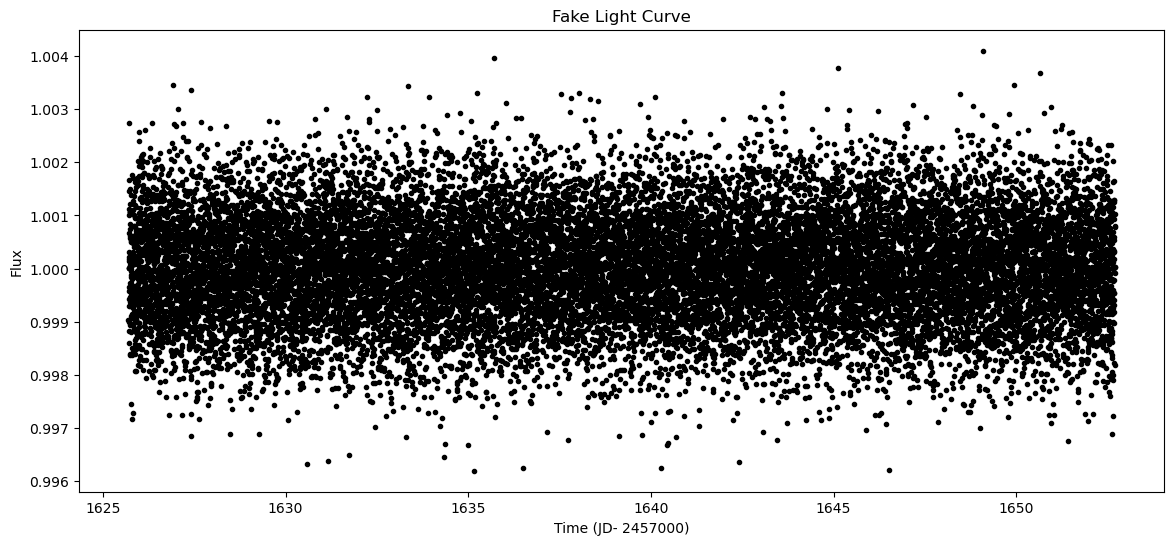

In [2]:
fs=10 # fontsize for text in figures
#ndays = 10 #days - the smaller number is for debugger for the TLS to run quicker


ndays = 27 #days
cadence_minutes = 2 # take measurement every 30 minutes
pts_per_day = (1 * 24 * 60) / cadence_minutes # data points per day
print(pts_per_day,'for cadence',cadence_minutes,'min')
scatter_frac = 0.001  # add scatter to data to make it realistic


start = 0.0
stop = ndays*1
stepsize = int(ndays * pts_per_day)


t = 2458625.7 + np.linspace(start, stop, stepsize) 

flux = 1.0 + np.random.randn(t.size) * scatter_frac
fluxerr = np.ones_like(flux) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.plot(t- 2457000,flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (JD- 2457000)")
plt.ylabel("Flux")
plt.title("Fake Light Curve")
# plt.ylim(0.9975,1.0025)
plt.show()



In [3]:
print(np.nanmedian(np.diff(t))*24*60,'minutes')

2.000103145837784 minutes


# need to make a stellar dictionary (for both transit injection and LEO-Vetter)

In [4]:
def calc_rho(M_star,R_star):
    from astropy.constants import G
    from astropy import units as u
    R_sun = u.R_sun.to('cm')
    M_sun = u.M_sun.to('g')
    M = M_star*M_sun
    R = R_star*R_sun
    rho=(M) / ( (4*np.pi/3) * ((R)**3)  )
    return rho
    
def calc_logg(M_star,R_star):
    from astropy.constants import G
    from astropy import units as u
    R_sun = u.R_sun.to('cm')
    M_sun = u.M_sun.to('g')
    M = M_star*M_sun
    R = R_star*R_sun
    
    g = G*(M / R**2 )
    return np.log10(g.cgs.value)

def get_rho_logg_qld(RS, MS, Teff):
    # defining astro constants
    import astropy.units as u
    R_earth = u.R_earth.to('cm')
    R_sun = u.R_sun.to('cm')
    M_sun = u.M_sun.to('g')
    R_star = RS #stellar radius in units of solar radii
    M_star = MS #stellar mass in units of solar mass
    
    
    rho = calc_rho(MS,RS) 
    logg= calc_logg(MS,RS)
    from leo_vetter.stellar import quadratic_ldc
    u1,u2 = quadratic_ldc(Teff, logg)
    qld = [u1,u2]
    return rho,logg,qld 



# useful function for calculating semi-major axis
def SMA_AU_from_Period_to_stellar(Period,R_star,M_star):
    """   
    This function will calculate the Semi-Major Axis (SMA)
    using Kepler's third law.
    
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in solar radii
    M_star : float
        Stellar Mass in solar masses
    Returns
    -------
        * SMA
            Semi-Major Axis in stellar units
        * SMA_cm
            Semi-Major Axis in units of centimeters        
    """    
    #assumes circular orbit
    #using Kepler's third law, calculate SMA
    #solar units
    import astropy.units as u
    from astropy import constants as const 
    RS = u.R_sun.to(u.cm) # in cm
    MS = u.M_sun.to(u.g) # in grams
    #
    G = const.G.cgs.value #cm^3 per g per s^2
    #
    R = R_star*RS
    M = M_star*MS
    P=Period*60.0*24.0*60.0 #in seconds
    #
    #SMA  
    SMA_cm = ((G*M*(P**2))/(4*(np.pi**2)))**(1/3)
    #
    #note R_star is already in solar units so we need to convert to cm using
    # solar radius as a constant
    Stellar_Radius = R #now in cm
    #
    SMA = SMA_cm / Stellar_Radius #now unitless (cm / cm)
    return SMA, SMA_cm




In [5]:
# need to make a stellar dictionary

ID = 0 #fake TESS Input Catalog ID
# defining astro constants
import astropy.units as u
R_earth = u.R_earth.to('cm')
R_sun = u.R_sun.to('cm')
M_sun = u.M_sun.to('g')
R_star = 0.5 #stellar radius in units of solar radii
M_star = 0.5 #stellar mass in units of solar mass


star = {'tic': ID,
 'rad': R_star,
 'e_rad': R_star/10,
 'mass': M_star,
 'e_mass': R_star/10,
 'Teff': 3500,
 'e_Teff': 3500/10}

rho,logg,qld = get_rho_logg_qld(R_star, M_star, star['Teff'])
star['rho']=rho
star['e_rho']=rho/100
star['logg']=logg
star['e_logg']=logg/100
star['u1']=qld[0]
star['u2']=qld[1]

star

{'tic': 0,
 'rad': 0.5,
 'e_rad': 0.05,
 'mass': 0.5,
 'e_mass': 0.05,
 'Teff': 3500,
 'e_Teff': 350.0,
 'rho': 5.639119297230102,
 'e_rho': 0.05639119297230102,
 'logg': 4.7390976229671145,
 'e_logg': 0.047390976229671145,
 'u1': 0.3109,
 'u2': 0.3446}

In [6]:
def predicted_transit_depth(injected_planet_radius, R_star,planet_units):
    import astropy.units as u
    if planet_units=='stellar':
        # convert from RP in stellair radii to RP in earth radii
        RP_earth = injected_planet_radius * (R_star * u.R_sun.to(u.cm)) / (u.R_earth.to(u.cm))
    if planet_units=='earth':
        RP_earth = injected_planet_radius 
    #print(injected_planet_radius_in_stellar_units,RP_earth)
    depth = ( (RP_earth * u.R_earth.to(u.cm)) / ( R_star*u.R_sun.to(u.cm) ) )**2
    return depth




def transit_injection(fake_time,fake_flux,fake_flux_err,
                     inject_P,inject_RP, inject_T0, RS, MS,qld=None):  # T0 - reference time / mid-transit time
    
    # defining astro constants
    import astropy.units as u
    R_earth = u.R_earth.to('cm')
    R_sun = u.R_sun.to('cm')
    M_sun = u.M_sun.to('g')
    R_star = RS #stellar radius in units of solar radii
    M_star = MS #stellar mass in units of solar mass

    # defining simulated transit parameters of orbiting planet
    P = inject_P #oribital period in days
    RP =  (inject_RP * R_earth / (R_star * R_sun) ) #planet radius in units of stellar radius

    #below is semi-major axis (see function above)
    SMA,SMA_cm = SMA_AU_from_Period_to_stellar(P,R_star,M_star) 

    time_start = inject_T0 #[0] =first data point in array

    # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
    ma.per = P  # orbital period
    ma.rp = RP  # planet radius (in units of stellar radii) 
    ma.a = SMA  # semi-major axis (in units of stellar radii)
    ma.inc = 90  # orbital inclination (in degrees)
    ma.ecc = 0  # eccentricity
    ma.w = 90  # longitude of periastron (in degrees)
    ma.u = [0.25, 0.25]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, fake_time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    #inject simulated transits into fake data
    injectedflux = synthetic_signal- fake_flux + 1

    plt.figure(figsize=(14,6)) #width, height
    plt.plot(fake_time- 2457000,injectedflux,marker='.',color='black',linestyle='none')
    plt.plot(fake_time- 2457000,synthetic_signal,marker='.',color='red',linestyle='none')

    plt.axhline(y=1-predicted_transit_depth(injected_planet_radius=(ma.rp),
                                       R_star=R_star,planet_units='stellar'),color='cyan',linestyle='--')

    plt.xlabel("Time (JD - 2457000)")
    plt.ylabel("Flux")
    plt.title("Transit Injected Fake Light Curve")
    plt.show()
    
    injected_LC = lk.LightCurve(time=fake_time,
                                flux=injectedflux,
                                flux_err=fake_flux_err)
    
    inj_model_LC = lk.LightCurve(time=fake_time,
                                 flux=synthetic_signal,
                                 flux_err=fake_flux_err)
    if type(qld)!=type(None):
        qld = [qld[0],qld[1]]
    else:
        qld = [0.25,0.25]
#     print(qld)
    fig=plt.figure(figsize=(14,6))
    ax=fig.add_subplot(111)
    injected_LC.fold(period=ma.per,epoch_time=ma.t0+ma.per).scatter(ax=ax,color='black')
    inj_model_LC.fold(period=ma.per,epoch_time=ma.t0+ma.per).plot(ax=ax,color='red',lw=3)
    ax.set_xlim(-12/24,12/24) #+/- 12 hours of injected transit
        
    ax.axhline(y=1-predicted_transit_depth(injected_planet_radius=(ma.rp),
                                       R_star=R_star,planet_units='stellar'),color='cyan',linestyle='--')
    
    plt.show()
    
    
    return injected_LC,inj_model_LC, qld

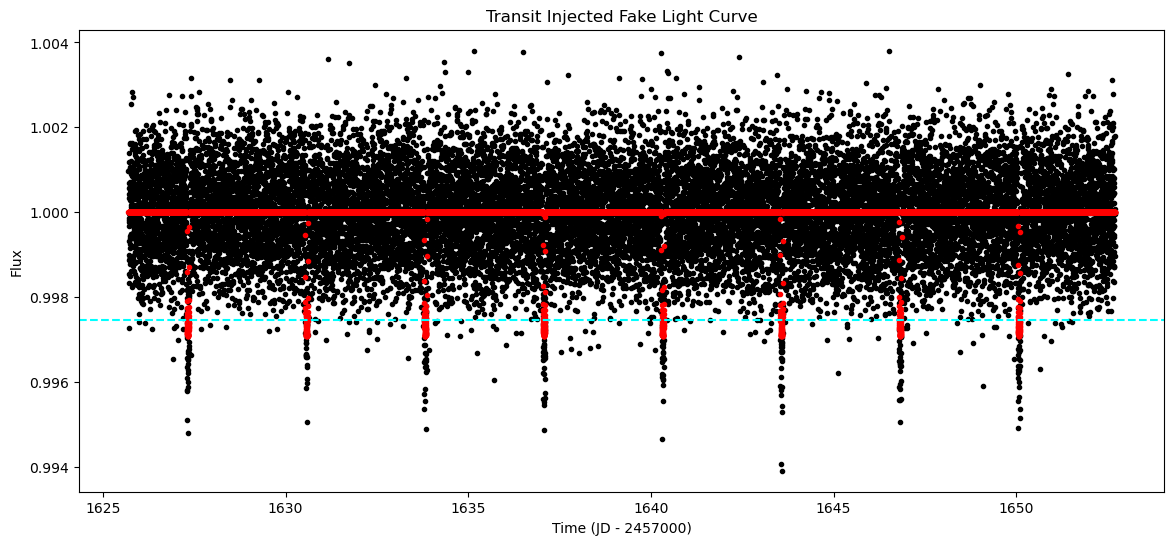

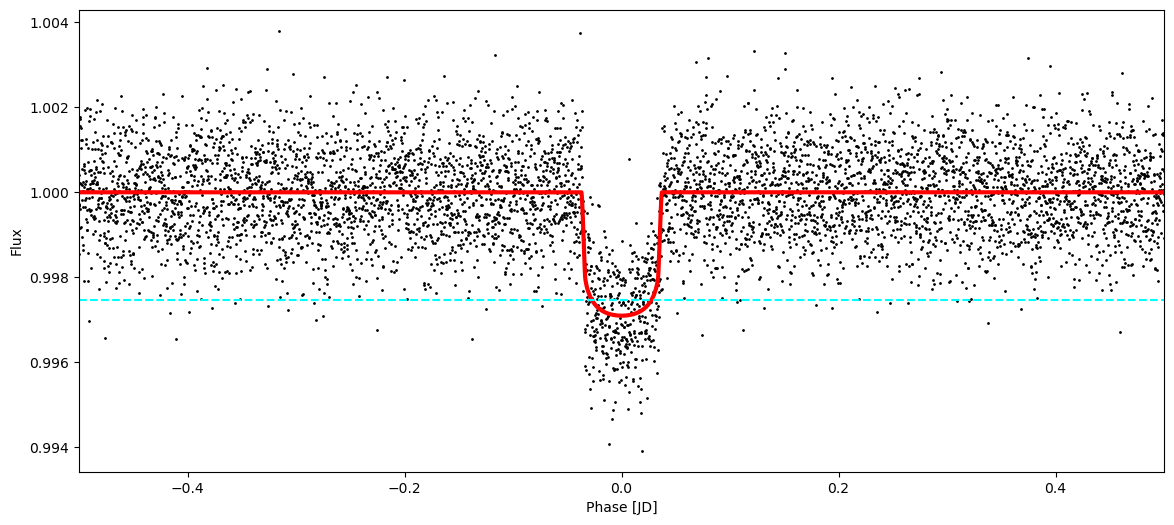

In [7]:


inj_RP1=2.75
inj_P1 = 3.25
inj_T0 = t[0]+inj_P1/2

injected_LC1,injected_model_LC1,qld1 = transit_injection(fake_time=t,
                                                         fake_flux=flux,
                                                         fake_flux_err=fluxerr,
                                                         inject_P=inj_P1,
                                                         inject_RP=inj_RP1, 
                                                         inject_T0=inj_T0, 
                                                         RS=star['rad'], 
                                                         MS=star['mass'],
                                                         qld=[star['u1'],star['u2']]
                                                        )


# With this simulated transit-injected light curve, can we use LEO vetter to vet the signal? And do so accurately?

In [8]:
from leo_vetter.stellar import quadratic_ldc #quadratic limb-darkened light curve
from leo_vetter.main import TCELightCurve # TCE =  Threshold Crossing Event light curve
from leo_vetter.plots import plot_modshift, plot_summary # 2 visual summaries of tests for validating transits
from leo_vetter.thresholds import check_thresholds # a series of automated tests for validating transits

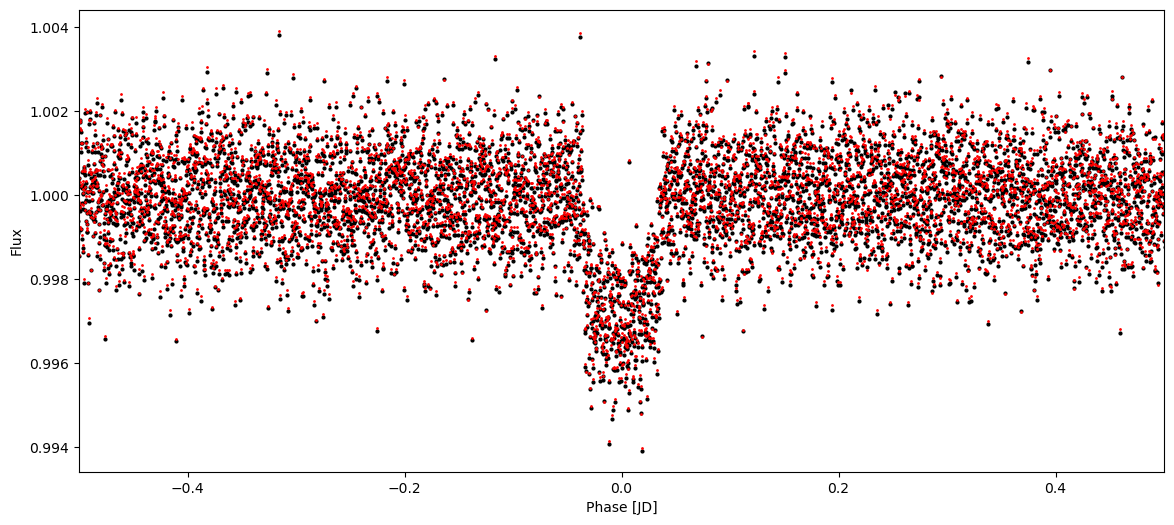

In [9]:
# smooth with wotan
def detrend(lc, window_length, filter_type, return_trend = True):
    '''
    Detrending light curves using wotan
    
    Inputs
    ------
    lc is the light curve object 
    
    window_length is the window size used for detrending (units of time)
    
    filter_type is a string that takes either Wotan or SG filters as an input
    
    return_trend if you want a trendline to be produced as an array
    
    
    Returns
    -------
    newlc returns the light curve objec with the detrended flux values
    
    trendlc returns the output of the trendline as an array
    
    '''
    
    if filter_type == "Wotan":
        from wotan import flatten
        import numpy as np

        flatten_lc, trend_lc = flatten(lc.time.value, lc.flux.value, 
                                       window_length = window_length, return_trend = return_trend)

        newlc = lk.LightCurve(time = lc.time.value, flux = flatten_lc, 
                              flux_err = lc.normalize().flux_err.value)
    if filter_type == "SG":
        npoints = convert_window_size_in_days_to_points(window_length, lc.time.value)
        newlc, trend_lc = lc.flatten(window_length = npoints, return_trend = return_trend)
        trend_lc = trend_lc.flux.value # SG model
        
    return newlc, trend_lc


newlc, trend_lc = detrend(injected_LC1, window_length=24/24, filter_type='Wotan', return_trend = True)



fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(111)
injected_LC1.fold(period=inj_P1,epoch_time=inj_T0).scatter(ax=ax,color='black',s=4**2)
newlc.fold(period=inj_P1,epoch_time=inj_T0).scatter(ax=ax,color='red',s=2**2)
ax.set_xlim(-12/24,12/24) #+/- 12 hours of injected transit



plt.show()

In [10]:
import os
def transit_searching_bls(lc, trend_lc, period_minimum, period_maximum, n_periods, filename,
                          frequency_factor = 500,savepath=os.getcwd()+'/',
                          injected_RP_in_earth_radii=None, R_star=None):
    '''
    search light curves for periodic transits using BLS then extract the best-fit BLS module parameters 
    (period, epoch, duration, depth), then with those paramters, it will face fold them
    
    
    Inputs
    -----
    lc = our light curve object
    
    trend_lc = shows the red line
    
    period_minimum = minimum period in our transit search
    
    period_maximum = maximun period in our transit search
    
    n_periods = the number of periods in our period grid (combinations of period related to BLS)
    
    filename is the name of our BLS transit search figure
    
    frequency_factor = 500 controls the spacing of the periods in our period grid
    
    savepath = location on machine where data products are saved to
    
    injected_RP_in_earth_radii = planet radius used for injected light curves  [in units of earth radii]
    
    R_star = stellar radius of star light curve is measured from [in units of solar radii]
    
    '''
    
    import numpy as np
    
    import matplotlib.gridspec as gridspec

    figure = plt.figure(figsize = (10, 10))
    gs = gridspec.GridSpec(2, 2)

    ax1 = figure.add_subplot(gs[0:1, 0:2]) # light curve w/ the trend line
    ax2 = figure.add_subplot(gs[1:, 0:1]) # BLS power graph
    ax3 = figure.add_subplot(gs[1:, 1:2]) # phase folded light curve
    
    # manually creating the plots
    ax1.scatter(lc.time.value - 2457000, lc.flux.value, color = 'black', s = 0.7)
    ax1.plot(lc.time.value - 2457000, trend_lc / np.nanmedian(trend_lc), color = 'r')
    ax1.set_xlabel('Time [TESS JD]')
    ax1.set_ylabel('Normalized Flux')
    
    period_grid = np.linspace(period_minimum, period_maximum, n_periods)
    
    # lightkurve
    bls = lc.to_periodogram(method = 'bls', period = period_grid, 
                            frequency_factor = frequency_factor)
    
    # for the bls power, calculating SDE and converting it from power
    bls_power = bls.power
    bls_sde = (bls_power - np.nanmean(bls_power)) / np.nanstd(bls_power)

    
    #bls.plot(ax = ax2, color = 'black', linewidth = 2);  # power spectrum plot
    
    # new power spectrum plot
    ax2.plot(1 / bls.frequency, bls_sde, color = 'black', linewidth = 2);
    
    period = bls.period_at_max_power
    
    # Plotting the strongest lines in the power spectrum plot and the harmonics
    ax2.axvline(x = period.value, color = 'r', linestyle = '-', alpha = 0.5)
    for i in range(2, 5):
        ax2.axvline(x = period.value * i, color = 'r', linestyle = '--', linewidth = 2, alpha = 0.5)
        ax2.axvline(x = period.value / i, color = 'r', linestyle = '--', linewidth = 2, alpha = 0.5)
    
    ax2.set_xlabel('Period [d]')
    ax2.set_ylabel('SDE')
    
    ax2.set_xlim(np.nanmin(period_grid) - 1, np.nanmax(period_grid) + 1)
    
    epoch = bls.transit_time_at_max_power
    
    duration = bls.duration_at_max_power
    
    depth = bls.depth_at_max_power  # units of light curve
    
    #calculate measured planet radius
    import astropy.units as u
    R_planet = np.sqrt(depth) * R_star * ( u.R_sun.to(u.cm) / u.R_earth.to(u.cm) )    
    
    #calculating best-fit BLS model
    BLS_lc = bls.get_transit_model(period=period,
                                   transit_time=epoch,
                                   duration=duration)
    
    
    folded_lc = lc.fold(period = period, epoch_time = epoch) # epoch is the reference time for BLS
    BLS_folded_lc = BLS_lc.fold(period = period, epoch_time = epoch)
    folded_lc.scatter(ax = ax3, color = 'black');
    BLS_folded_lc.plot(ax = ax3,  color = 'cyan',linestyle='-',lw=3);    
    ax3.set_ylabel('Normalized Flux')
    
    ax3.set_xlim(-4 * duration.value, 4 * duration.value) # negative numbers are yesterdays, 0 is present, 
    ax3.axhline(y = 1 - depth, color = 'r')                            # and positive numbers are tomorrows
    ax3.axvline(x = 0 - duration.value, color = 'r')
    ax3.axvline(x = 0 + duration.value, color = 'r')
    
    
    # if injected_RP_in_stellar_radii is provided as an input,
    # plot the predicted transit depths as horizontal lines
    if type(injected_RP_in_earth_radii) != type(None):    
        ax1.axhline(y=1-predicted_transit_depth(injected_planet_radius=injected_RP_in_earth_radii,
                                   R_star=R_star,planet_units='earth'),color='cyan',linestyle='--')
        ax3.axhline(y=1-predicted_transit_depth(injected_planet_radius=injected_RP_in_earth_radii,
                                   R_star=R_star,planet_units='earth'),color='cyan',linestyle='--')
        
    # add text over power spectrum and phase-folded LC to show best-fit TLS params
    ax2.set_title('BLS Period = ' + str( np.round ( period , 3) ) +' days' )
    ax3.set_title('BLS Planet Radius = ' + str( np.round ( R_planet , 3) ) +' $R_{\oplus}$' )        
    
    gs.tight_layout(figure, pad = 1)
    figure.savefig(savepath+filename, bbox_inches = "tight")
    plt.show();
    
    df = pd.DataFrame({"Period": period, "Epoch": epoch, "Duration": duration, 
                       "Depth": depth,'Radius':R_planet}, index = [0])
    
    df.to_csv(savepath+filename[:-4] + ".csv")
    
    return period, epoch, duration, depth

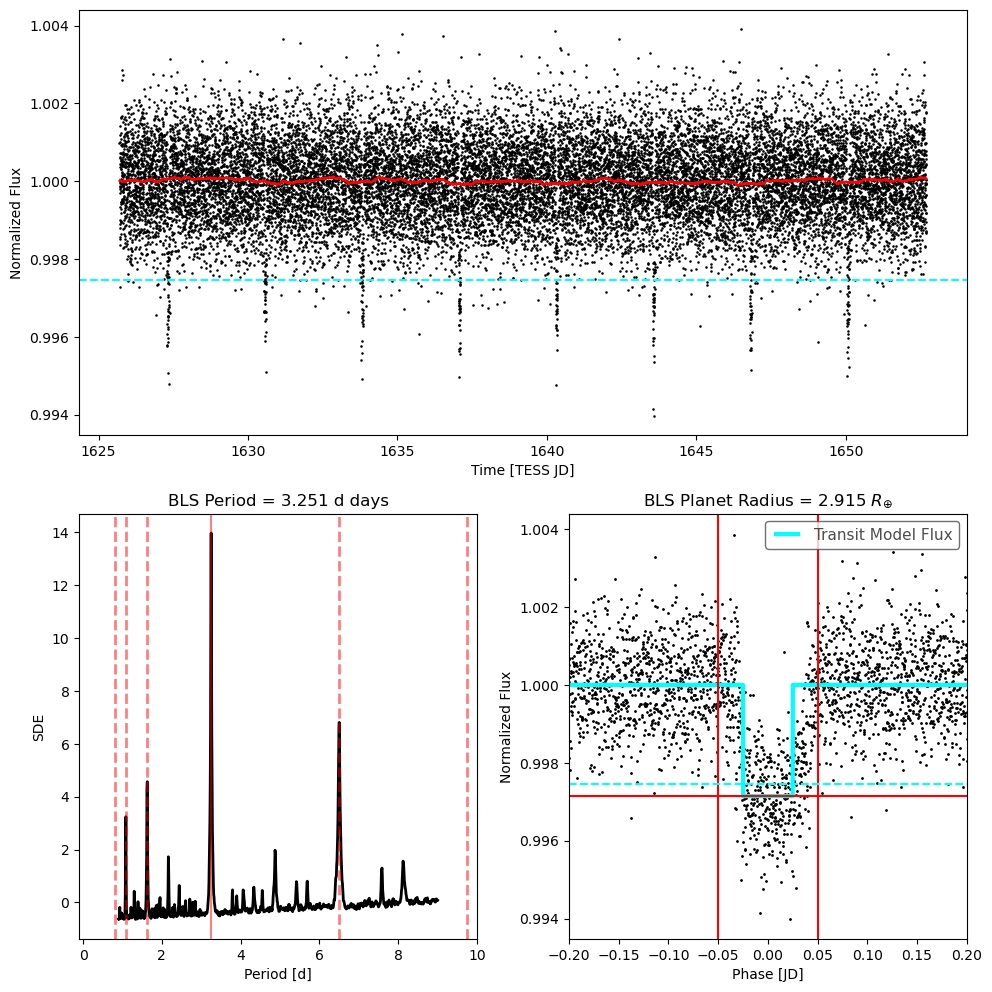

In [11]:

period, epoch, duration, depth = transit_searching_bls(lc = newlc, trend_lc = trend_lc,
                                                       period_minimum = 0.9, 
                                                       period_maximum = (np.nanmax(newlc.time.value)-np.nanmin(newlc.time.value))/3, 
                                                       n_periods = 1000, 
                                                       filename = "TIC_"+str(ID)+"_BLS.png", 
                                                       frequency_factor = 1000,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star)


In [12]:


#make sure NaNs are gone
nanmask = np.where(np.isfinite(newlc.flux.value)==True)[0]


tlc = TCELightCurve(tic=ID, 
                    time=newlc.time.value[nanmask]-2457000,
                    raw=injected_LC1.flux.value[nanmask],
                    flux=newlc.flux.value[nanmask],
                    flux_err=newlc.flux_err.value[nanmask], 
                    per=period.value, 
                    epo=epoch.value, 
                    dur=duration.value,  #duration in days
                    planetno=1)

In [13]:
# if we want to collect a "stellar dictionary" from the TIC
def collect_TIC_params(TIC_ID):
    from astroquery.mast import Catalogs
    result = Catalogs.query_criteria(catalog="TIC", ID=TIC_ID)
    star = {}
    star["tic"] = TIC_ID
    for key in ["rad","mass","rho","Teff","logg"]:
        star[key] = float(result[key])
        star["e_"+key] = float(result["e_"+key])

    # Get limb-darkening parameters from Teff and logg
    star["u1"], star["u2"] = quadratic_ldc(star["Teff"], star["logg"])
    return star

# combine both summary figures into a single PDF file
def combine_PDFs(TIC_ID,remove_orig_files=True):
#     from PyPDF2 import PdfFileMerger, PdfFileReader, PdfMerger,PdfReader
#     import PyPDF2
    from PyPDF2 import PdfMerger,PdfReader
    merger = PdfMerger()   
    multipage_output_filename = 'TIC_'+str(ID)+'_LEOVetter_validation_report.pdf'
    input_files = ['TIC_'+str(ID)+'_LEOVetter_summary.pdf',
                   'TIC_'+str(ID)+'_LEOVetter_modshift.pdf']
    for x in range(len(input_files)):
        input_file = input_files[x]
        pdfinput = PdfReader(open(input_file,'rb'))
        merger.append((pdfinput))
    merger.write(multipage_output_filename)
    
    if remove_orig_files==True:
        import os
        for x in range(len(input_files)):
            os.system('rm -r '+str(input_files[x]))

def apply_LEOVetter(TIC_ID, time,raw_flux, detrended_flux, detrended_flux_err,
                    period, T0, duration, 
                   star_params=None,remove_orig_files=True):
    '''
    This function will apply LEO-Vetter to validation detected 
    transit signals in an input light curve.
    ----------------------------------------------------------
    ----------------------------------------------------------
    
    Inputs:
        TIC_ID: TESS Input Catalog ID number, int
        time: array of timestamps of input light curve, np.array
        raw_flux: array of raw flux values of input light curve, np.array
        detrended_flux: array of detrended flux values of input light curve, np.array
        detrended_flux_err: array of detrended flux uncertainty values 
                            of input light curve, np.array
        period: orbital period of detected transit signal, in units of days
        T0: reference time (or mid-transit time or epoch) of 
            detected transit signal, in units of time 
        duration: transit duration of detected transit signal, 
                in units of days
    
    Outputs:
        metrics: List of measurements from various automated transit 
                 vetting tests, pandas DataFrame
        summary_figure: multi-page PDF saved to file (not actually output by function)
    '''
    if type(star_params)==type(None):
        star_params = collect_TIC_params(TIC_ID)
        
        
        
    nanmask = np.where(np.isfinite(detrended_flux)==True)[0]

    
    tlc = TCELightCurve(tic=TIC_ID, 
                        time=time[nanmask],
                        raw=raw_flux[nanmask],
                        flux=detrended_flux[nanmask],
                        flux_err=detrended_flux_err[nanmask], 
                        per=period, epo=T0,  dur=duration,
                        planetno=1)
    
    tlc.compute_flux_metrics(star, verbose=True )
    # The default filename is "(tic).(planetno).metrics", but you
    # can give this function any desired filename as an input. 
    tlc.save_metrics('TIC_'+str(ID)+'_LEOVetter_metrics.csv')
    metrics = pd.read_csv('TIC_'+str(ID)+'_LEOVetter_metrics.csv')
    
    # save figures
    plot_summary(tlc, star, save_fig=True,save_file='TIC_'+str(ID)+'_LEOVetter_summary.pdf')
    plot_modshift(tlc, save_fig=True,save_file='TIC_'+str(ID)+'_LEOVetter_modshift.pdf')
    
    combine_PDFs(TIC_ID,remove_orig_files=remove_orig_files)
    
    print('\n============\n')
    print('False Alarm tests:')
    FA = check_thresholds(tlc.metrics, "FA", verbose=True) # FA is True if any tests failed; False otherwise
    print('\n============\n')
    print('False Positive tests:')
    FP = check_thresholds(tlc.metrics, "FP", verbose=True) # FP is True if any tests failed; False otherwise
    print('\n============\n')
    print(' ')
    if not FA and not FP:
        print(f"TIC-{tlc.tic}.{tlc.planetno} is a planet candidate!")
    
    return metrics

Estimating SES and MES time series...


/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/leo_vetter/utils.py:17: RuntimeWarning: invalid value encountered in double_scalars
  mean = np.sum(w * y) / np.sum(w)
/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/leo_vetter/utils.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  err = 1 / np.sqrt(np.sum(w))


Fitting linear, trapezoid, and transit models...
Running SWEET test...
Getting odd-even metrics...
Checking individual transit events...
Running modshift...
Estimating derived parameters...
Done!


False Alarm tests:
Passed all FA tests


False Positive tests:
Passed all FP tests


 
TIC-0.1 is a planet candidate!


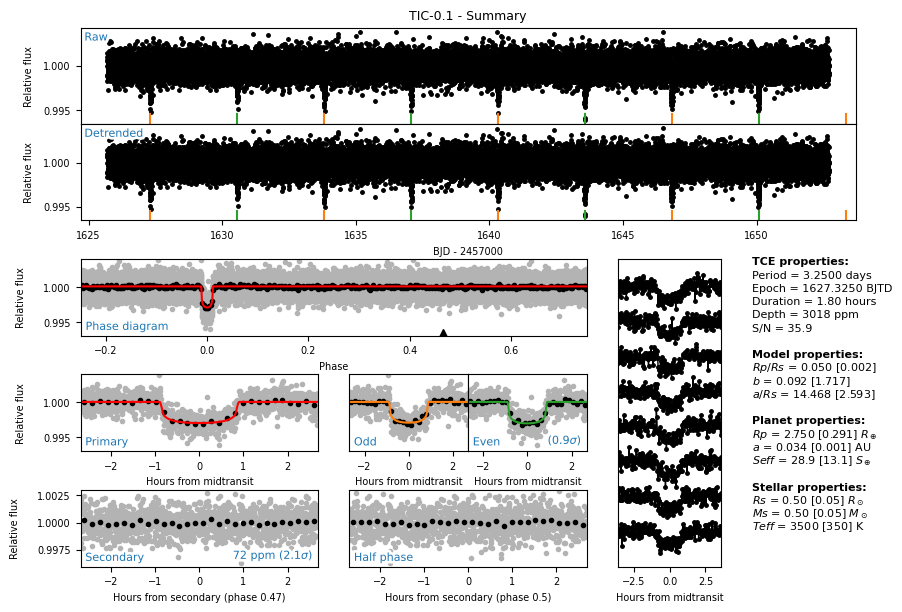

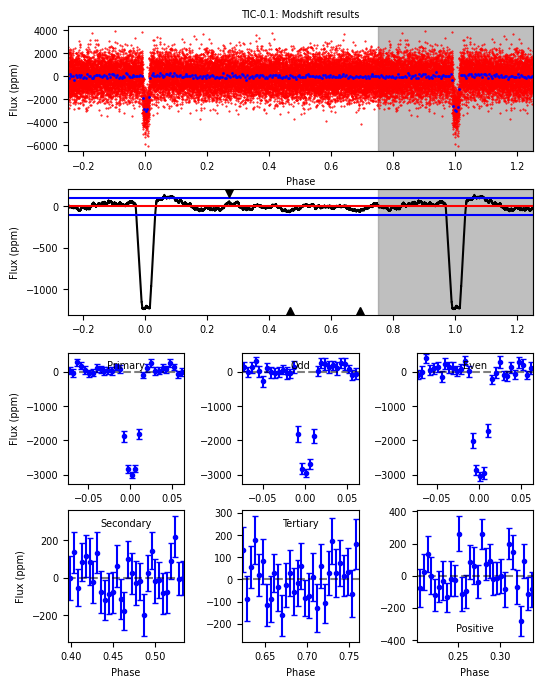

In [14]:
m = apply_LEOVetter(TIC_ID=ID, 
                    time=newlc.time.value-2457000,
                    raw_flux=injected_LC1.flux.value, 
                    detrended_flux=newlc.flux.value,
                    detrended_flux_err=newlc.flux_err.value,
                    period=period.value, 
                    T0=epoch.value-2457000, 
                    duration=3*duration.value, 
                   star_params=star)

# compare with injected params

In [15]:
print(inj_P1, 'd',inj_RP1,'Earth Radii',inj_T0-2457000,'BTJD')

3.25 d 2.75 Earth Radii 1627.3250000001863 BTJD


# automated vettings thresholds can be found here:
# https://github.com/mkunimoto/LEO-vetter/blob/main/leo_vetter/thresholds.py

# attempting to make EB injection code below (it's not working well...)

In [16]:
# def simulate_EB_transit(time: np.ndarray, R_EB: float,
#                         EB_fluxratio: float, P_orb: float, inc: float,
#                         a: float, R_s: float, u1: float, u2: float,
#                         companion_fluxratio: float = 0.0,
#                         companion_is_host: bool = False):
#     """
#     Simulates a eclipsing binary light curve using BATMAN.
#     Args:
#         time (numpy array): Time of each data point
#                             [days from transit midpoint].
#         R_EB (float): EB radius [Solar radii].
#         EB_fluxratio (float): F_EB / (F_EB + F_target).
#         P_orb (float): Orbital period [days].
#         inc (float): Orbital inclination [degrees].
#         a (float): Semimajor axis [cm].
#         R_s (float): Star radius [Solar radii].
#         u1 (float): 1st coefficient in quadratic limb darkening law.
#         u2 (float): 2nd coefficient in quadratic limb darkening law.
#         companion_fluxratio (float): F_comp / (F_comp + F_target).
#         companion_is_host (bool): True if the transit is around the
#                                   unresolved companion and False if it
#                                   is not.
#     Returns:
#         m.light_curve (numpy array): Normalized flux at eat time given.
#     """
#     import astropy.units as u
#     R_earth = u.R_earth.to('cm')
#     Rsun = u.R_sun.to('cm')
#     Msun = u.M_sun.to('g')    
#     F_target = 1
#     F_comp = companion_fluxratio/(1-companion_fluxratio)
#     F_EB = EB_fluxratio/(1-EB_fluxratio)
#     # step 1: simulate light curve assuming only the host star exists
#     params = batman.TransitParams()
#     # calculate primary eclipse
#     params.t0 = 0.0
#     params.per = P_orb
#     if R_EB/R_s == 1.0:
#         params.rp = R_EB/R_s * 0.999
#     else:
#         params.rp = R_EB/R_s
#     params.a = a/(R_s*Rsun)
#     params.inc = inc
#     params.ecc = 0.0
#     params.w = 0.0
#     params.u = [u1, u2]
#     params.limb_dark = "quadratic"
#     flux = batman.TransitModel(params, time).light_curve(params)
#     # calculate secondary eclipse depth
#     params.fp = (EB_fluxratio)/(1-EB_fluxratio)
#     params.t_secondary = 0.5
#     sec = batman.TransitModel(
#         params, np.array([0.5, 0.75]), transittype="secondary"
#         )
#     sec_flux = sec.light_curve(params)[0]/max(sec.light_curve(params))
#     # step 2: adjust the light curve to account for flux dilution
#     # from EB and non-host star
#     if companion_is_host:
#         flux = (flux + F_EB/F_comp) / (1 + F_EB/F_comp)
#         F_dilute = F_target / (F_comp + F_EB)
#         flux = (flux + F_dilute)/(1 + F_dilute)
#         secdepth = 1 - (sec_flux + F_dilute)/(1 + F_dilute)
#     else:
#         flux = (flux + F_EB/F_target) / (1 + F_EB/F_target)
#         F_dilute = F_comp / (F_target + F_EB)
#         flux = (flux + F_dilute)/(1 + F_dilute)
#         secdepth = 1 - (sec_flux + F_dilute)/(1 + F_dilute)
#     return flux, secdepth


# def transit_injection_EB(fake_time,fake_flux,fake_flux_err,
#                      inject_P,inject_R_EB, inject_T0, RS, MS,
#                          companion_fluxratio=0, companion_is_host=False,
#                         EB_fluxratio=0.5):  # T0 - reference time / mid-transit time
#     # companion_fluxratio (float): F_comp / (F_comp + F_target).
#     F_target = 1
#     F_comp = companion_fluxratio/(1-companion_fluxratio)
#     F_EB = EB_fluxratio/(1-EB_fluxratio)
    
    
    
#     # defining astro constants
#     import astropy.units as u
#     R_earth = u.R_earth.to('cm')
#     R_sun = u.R_sun.to('cm')
#     M_sun = u.M_sun.to('g')
#     R_star = RS #stellar radius in units of solar radii
#     M_star = MS #stellar mass in units of solar mass

#     # defining simulated transit parameters of orbiting planet
#     P = inject_P #oribital period in days
    
#     R_EB =  (inject_R_EB * R_sun  ) #EB secondary radius in units of stellar radius

#     #below is semi-major axis (see function above)
#     SMA,SMA_cm = SMA_AU_from_Period_to_stellar(P,R_star,M_star) 

#     time_start = inject_T0 #[0] =first data point in array

#     # Use batman to create transits
#     ma = batman.TransitParams()
    
#     if R_EB/R_sun == 1.0:
#         ma.rp = R_EB/R_sun * 0.999
#     else:
#         ma.rp = R_EB/R_sun
    
    
#     ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
#     ma.per = P  # orbital period
#     ma.a = SMA  # semi-major axis (in units of stellar radii)
#     ma.inc = 90  # orbital inclination (in degrees)
#     ma.ecc = 0  # eccentricity
#     ma.w = 0  # longitude of periastron (in degrees)
#     ma.u = [0.25, 0.25]  # limb darkening coefficients
#     ma.limb_dark = "quadratic"  # limb darkening model
#     m = batman.TransitModel(ma, fake_time)  # initializes model
#     synthetic_signal = m.light_curve(ma)  # calculates light curve
    
#     # calculate secondary eclipse depth
#     ma.fp = 0.0001#(EB_fluxratio)/(1-EB_fluxratio)
#     ma.t_secondary = time_start# + P / 2.
    
#     sec = batman.TransitModel(ma, np.array([0.5, 0.75]), transittype="secondary")
#     sec_flux = sec.light_curve(ma)[0]#/np.max(sec.light_curve(ma))
#     # step 2: adjust the light curve to account for flux dilution
#     # from EB and non-host star
#     # companion_is_host: True if the transit is around the unresolved 
#     # companion and False if it is not.
    
#     if companion_is_host:
#         flux = (synthetic_signal + F_EB/F_comp) / (1 + F_EB/F_comp)
#         F_dilute = F_target / (F_comp + F_EB)
#         flux = (synthetic_signal + F_dilute)/(1 + F_dilute)
#         secdepth = 1 - (sec_flux + F_dilute)/(1 + F_dilute)
#     else:
#         flux = (synthetic_signal + F_EB/F_target) / (1 + F_EB/F_target)
#         F_dilute = F_comp / (F_target + F_EB)
#         flux = (synthetic_signal + F_dilute)/(1 + F_dilute)
#         secdepth = 1 - (sec_flux + F_dilute)/(1 + F_dilute)

#     #inject simulated transits into fake data
#     injectedflux = synthetic_signal- fake_flux + 1
#     injectedflux = injectedflux-(sec_flux)  + 1
#     injectedflux/=np.nanmedian(injectedflux)

#     plt.figure(figsize=(14,6)) #width, height
#     plt.plot(fake_time- 2457000,injectedflux,marker='.',color='black',linestyle='none')
#     plt.plot(fake_time- 2457000,synthetic_signal,marker='.',color='red',linestyle='none')

#     plt.axhline(y=1-predicted_transit_depth(injected_planet_radius=(ma.rp),
#                                        R_star=R_star,planet_units='stellar'),color='cyan',linestyle='--')

#     plt.xlabel("Time (JD - 2457000)")
#     plt.ylabel("Flux")
#     plt.title("Transit Injected Fake Light Curve")
#     plt.show()
    
#     injected_LC = lk.LightCurve(time=fake_time,
#                                 flux=injectedflux,
#                                 flux_err=fake_flux_err)
    
#     inj_model_LC = lk.LightCurve(time=fake_time,
#                                  flux=synthetic_signal,
#                                  flux_err=fake_flux_err)
    
#     qld = [0.25,0.25]
    
#     fig=plt.figure(figsize=(14,6))
#     ax=fig.add_subplot(111)
#     injected_LC.fold(period=ma.per,epoch_time=ma.t0+ma.per/2).scatter(ax=ax,color='black')
#     inj_model_LC.fold(period=ma.per,epoch_time=ma.t0+ma.per/2).plot(ax=ax,color='red',lw=3)
# #     ax.set_xlim(-1,1) #+/- 12 hours of injected transit
        
#     ax.axhline(y=1-predicted_transit_depth(injected_planet_radius=(ma.rp),
#                                            R_star=R_star,planet_units='stellar'),
#                color='cyan',linestyle='--')
    
#     plt.show()
    
#     return injected_LC,inj_model_LC,qld

In [17]:
print('done!')

done!
